In [1]:
import numpy as np
import astropy.units as u

# Some plotting functions

In [2]:
import pylab as plt

In [3]:
from snewpy.rate_calculator import SmearingMatrix, DetectionChannel

In [4]:
def plot_matrix(m: SmearingMatrix):
    plt.pcolormesh(m.bins_true.value, m.bins_smeared.value, m.matrix.T)
    plt.xlabel('$E_{true}$, '+m.bins_true.unit._repr_latex_())
    plt.ylabel('$E_{smeared}$, '+m.bins_smeared.unit._repr_latex_())

In [5]:
def plot_quantity(x:u.Quantity, y:u.Quantity, xlabel=None, ylabel=None, **kwargs):
    """Plot the X vs Y array, with given axis labels, adding units"""

    #just in case we are passed bare np.arrays iwthout units
    x = u.Quantity(x)
    y = u.Quantity(y)
    
    if(len(x)==len(y)):
        plt.plot(x.value,y.value,**kwargs)
    else:
        plt.stairs(edges=x.value,values=y.value,**kwargs)
    if xlabel is not None:
        if(not x.unit.is_unity()):
            xlabel+=', '+x.unit._repr_latex_()
        plt.xlabel(xlabel)
    if ylabel is not None:
        if(not y.unit.is_unity()):
            ylabel+=', '+y.unit._repr_latex_()
        plt.ylabel(ylabel)

In [16]:
def plot_rate(rate, axis:str='time', **kwargs):
    if axis=='time':
        x = rate.time.to('s')
        y = rate.integrate_or_sum('energy').array.squeeze()
    elif axis=='energy':
        x = rate.energy.to('MeV')
        y = rate.integrate_or_sum('time').array.squeeze()
    else: 
        raise ValueError(f'axis="{axis}" should be one of "time","energy"')
    plot_quantity(x,y,xlabel=axis.capitalize(), ylabel='Event rate', **kwargs)


# Prepare the neturino flux

In [17]:
# prepare the neutrino flux from the model
from snewpy.models import ccsn
model = ccsn.Bollig_2016(progenitor_mass=27<<u.Msun)
times    = np.linspace(0,2,1500)<<u.second;
energies = np.linspace(0,50,501)<<u.MeV
flux = model.get_flux(t = times, E = energies, distance=10<<u.kpc)

# Reading the detector config from SNOwGLoBES

In [18]:
from snewpy.rate_calculator import RateCalculator

#load the RateCalculator object
rc = RateCalculator()

## List available detectors

In [19]:
#list available detectors
list(rc.detectors)

['wc100kt30prct',
 'wc100kt15prct',
 'ar40kt',
 'scint20kt',
 'halo1',
 'halo2',
 'novaND',
 'novaFD',
 'wc100kt30prct_he',
 'ar40kt_he',
 'icecube',
 'km3net',
 'ds20',
 'argo',
 'lz',
 'xent',
 'pandax']

## Read the detector you need

In [20]:
#read the detector
det = rc.read_detector('icecube')
det

Detector(name="icecube", mass=51600.0 kt, channels=['ibd', 'nue_e', 'nuebar_e', 'numu_e', 'numubar_e', 'nutau_e', 'nutaubar_e', 'nue_O16', 'nuebar_O16', 'nc_nue_O16', 'nc_nuebar_O16', 'nc_numu_O16', 'nc_numubar_O16', 'nc_nutau_O16', 'nc_nutaubar_O16'])

## Inspecting the detector

In [21]:
#list all the channels
det.channels

{'ibd': DetectionChannel (name=ibd, flavor=NU_E_BAR, smearing=True),
 'nue_e': DetectionChannel (name=nue_e, flavor=NU_E, smearing=True),
 'nuebar_e': DetectionChannel (name=nuebar_e, flavor=NU_E_BAR, smearing=True),
 'numu_e': DetectionChannel (name=numu_e, flavor=NU_X, smearing=True),
 'numubar_e': DetectionChannel (name=numubar_e, flavor=NU_X_BAR, smearing=True),
 'nutau_e': DetectionChannel (name=nutau_e, flavor=NU_X, smearing=True),
 'nutaubar_e': DetectionChannel (name=nutaubar_e, flavor=NU_X_BAR, smearing=True),
 'nue_O16': DetectionChannel (name=nue_O16, flavor=NU_E, smearing=True),
 'nuebar_O16': DetectionChannel (name=nuebar_O16, flavor=NU_E_BAR, smearing=True),
 'nc_nue_O16': DetectionChannel (name=nc_nue_O16, flavor=NU_E, smearing=True),
 'nc_nuebar_O16': DetectionChannel (name=nc_nuebar_O16, flavor=NU_E_BAR, smearing=True),
 'nc_numu_O16': DetectionChannel (name=nc_numu_O16, flavor=NU_X, smearing=True),
 'nc_numubar_O16': DetectionChannel (name=nc_numubar_O16, flavor=NU_X_

/home/ash/work/snews2/snewpy/python/snewpy/rate_calculator.py:318: RuntimeWarning: divide by zero encountered in log
  return np.interp(np.log(E)/np.log(10), xp, yp, left=0, right=0)*E*1e-38 <<u.cm**2


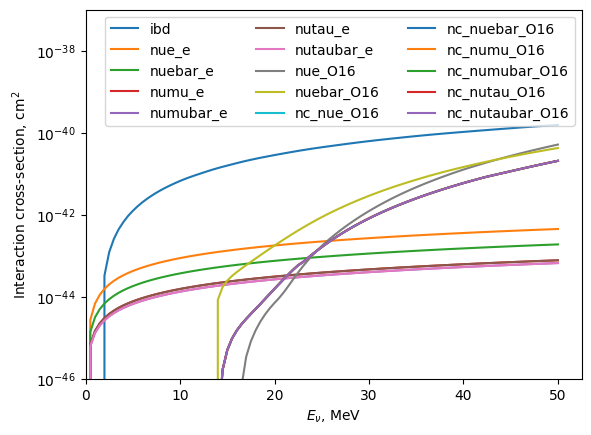

In [22]:
#plot all the channels cross-sections
E = np.linspace(0,50,101)<<u.MeV
for chan in det.channels.values():
    xs = chan.xsec(E)
    plot_quantity(E, xs, r'$E_\nu$', r'Interaction cross-section', label=chan.name)
plt.legend(ncols=3)
plt.yscale('log')
plt.xlim(0)
plt.ylim(1e-46, 1e-37)
plt.show()

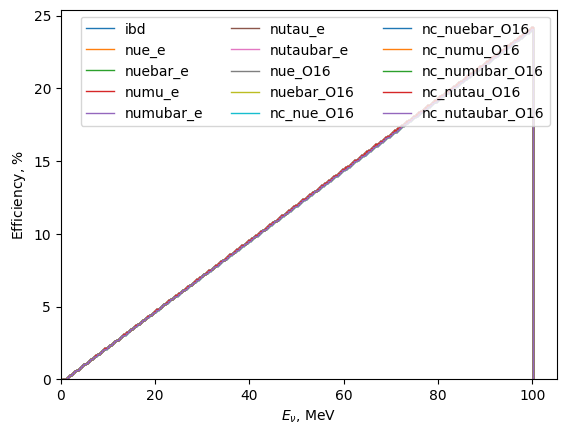

In [23]:
#plot all the channels efficiencies
for chan in det.channels.values():
    E = chan.smearing.bins_smeared<<u.MeV
    eff = chan.efficiency*100*u.percent
    plot_quantity(E, eff, r'$E_\nu$', r'Efficiency', label=chan.name)
plt.legend(ncols=3)
plt.xlim(0)
plt.ylim(0)
plt.show()

In [24]:
e_true = det.channels['ibd'].smearing.bins_true << u.MeV
e_smear = det.channels['ibd'].smearing.bins_smeared << u.MeV

## Running the rate calculation

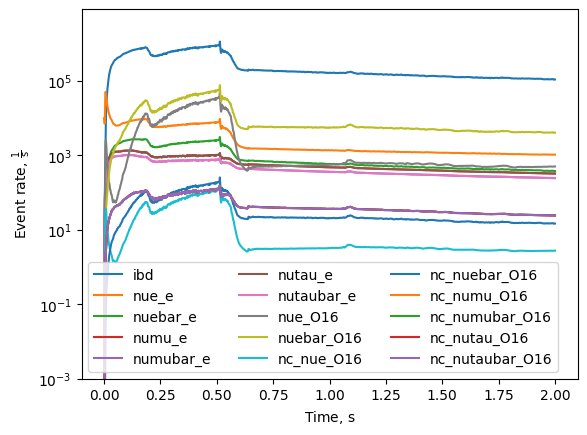

In [35]:
rates = det.run(flux)
for chan,rate in rates.items():
    #integrate over energy
    plot_rate(rate, axis='time', label=chan)
plt.legend(ncols=3)
plt.yscale('log')
plt.ylim(1e-3)
plt.show()

# Defining a new detector

In [37]:
from snewpy.neutrino import Flavor
from snewpy.rate_calculator import Detector, DetectionChannel
#we can load cross-section directly from SNOwGLoBES to reuse
xsec_ibd=rc.load_xsec('ibd',Flavor.NU_E_BAR) 
# we can define smearing matrices 
e_true  = np.linspace(0,50,501)<<u.MeV
e_smear = np.linspace(0,50,501)<<u.MeV
#matrices with same shift of 0.87 MeV in mean value, but with different resolution
m_smear_0=SmearingMatrix.from_Gaussian(e_true,e_smear, 
                                       mean=lambda e:e-0.87*u.MeV)
m_smear_1prc=SmearingMatrix.from_Gaussian(e_true,e_smear, 
                                       mean=lambda e:e-0.87*u.MeV, 
                                       sigma=lambda e:0.01*e)
m_smear_5prc=SmearingMatrix.from_Gaussian(e_true,e_smear, 
                                       mean=lambda e:e-0.87*u.MeV, 
                                       sigma=lambda e:0.05*e)
ibd_channel = DetectionChannel(flavor=Flavor.NU_E_BAR,xsec=xsec_ibd, efficiency=1., smearing = m_smear_0)
det = Detector('scint_det', mass=300<<u.kt, 
               channels={
                   'ibd_nosmear':DetectionChannel(flavor=Flavor.NU_E_BAR,xsec=xsec_ibd, efficiency=1., smearing = m_smear_0),
                   'ibd_smear_1%':DetectionChannel(flavor=Flavor.NU_E_BAR,xsec=xsec_ibd, efficiency=1., smearing = m_smear_1),
                   'ibd_smear_5%':DetectionChannel(flavor=Flavor.NU_E_BAR,xsec=xsec_ibd, efficiency=1., smearing = m_smear_5)
               })

TypeError: DetectionChannel.__init__() missing 1 required positional argument: 'name'

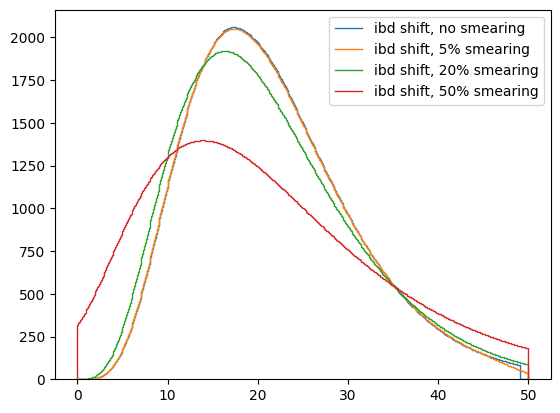

In [36]:
rates = det.run(flux)
for chan in cha

det.channels['ibd'].smearing = smearing=SmearingMatrix.from_Gaussian(
    e_true,e_smear,
    loc=lambda e:e-0.87*u.MeV,
    scale=lambda e:e*0.05,
)
plot_rate(det.run(flux)['ibd'], label='ibd shift, 5% smearing')

det.channels['ibd'].smearing = smearing=SmearingMatrix.from_Gaussian_blur(
    e_true,e_smear,
    loc=lambda e:e-0.87*u.MeV,
    scale=lambda e:e*0.2,
)
plot_rate(det.run(flux)['ibd'], label='ibd shift, 20% smearing')

det.channels['ibd'].smearing = smearing=SmearingMatrix.from_Gaussian_blur(
    e_true,e_smear,
    loc=lambda e:e-0.87*u.MeV,
    scale=lambda e:e*0.5,
)
plot_rate(det.run(flux)['ibd'], label='ibd shift, 50% smearing')

plt.legend()
plt.show()